# Introduction to the MNIST database

In the following tutorials, we are going to use the MNIST database of handwritten digits. MNIST is a simple computer vision dataset of handwritten digits. It has 60,000 training examles and 10,000 test examples. "It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting." For more details of this database, please checkout the website [MNIST](http://yann.lecun.com/exdb/mnist/).

In BigDL, we have already provided a utility method to download and read the MNIST data.

In [1]:
import matplotlib
matplotlib.use('Agg')
# As always, a bit of setup
%pylab inline
import pandas
from bigdl.dataset import mnist
from bigdl.util.common import *
import matplotlib.pyplot as plt
from pyspark import SparkContext
from matplotlib.pyplot import imshow
sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))
init_engine()

Populating the interactive namespace from numpy and matplotlib
Prepending /usr/local/lib/python2.7/dist-packages/bigdl/share/conf/spark-bigdl.conf to sys.path


We can use *mnist.read_data_sets* method to download and read mnist data into memory as numpy ndarray.

In [2]:
mnist_path = "datasets/mnist"
(train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
(test_images, test_labels) = mnist.read_data_sets(mnist_path, "test")

print train_images.shape
print train_labels.shape
print test_images.shape
print test_labels.shape

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


The training set consists of 60000 examples and the test set consits of 10000 examples. Each example is a 28x28 pixel image represting a handwritten digit. Let's see some first ten examples and their lables.

groud true labels: 
[5 0 4 1 9 2 1 3 1 4]


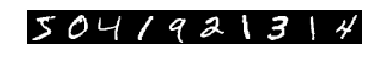

In [3]:
imshow(np.column_stack(train_images[0:10].reshape(10, 28,28)),cmap='gray'); plt.axis('off')
print "groud true labels: "
print train_labels[0:10]

To use mnist dataset in bigdl, we have to transform the ndarrays to rdd of Sample. And neural networks tends to work better with zero-mean and unit variance data, we'd better normalize the images.

In [4]:
rdd_train_images = sc.parallelize(train_images)
rdd_train_labels = sc.parallelize(train_labels)
rdd_test_images = sc.parallelize(test_images)
rdd_test_labels = sc.parallelize(test_labels)
training_mean = np.mean(train_images)
training_std = np.std(train_images)
rdd_train_sample = rdd_train_images.zip(rdd_train_labels).map(lambda (features, label):
                    Sample.from_ndarray((features - training_mean)/training_std, label + 1))
rdd_test_sample = rdd_test_images.zip(rdd_test_labels).map(lambda (features, label):
                    Sample.from_ndarray((features - training_mean)/training_std, label + 1))
print rdd_train_sample.count()
print rdd_test_sample.count()

60000
10000


We can create a small utility method for future use.

In [5]:
def get_mnist(sc, mnist_path):
    # target is start from 0,
    (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
    (test_images, test_labels) = mnist.read_data_sets(mnist_path, "test")
    training_mean = np.mean(train_images)
    training_std = np.std(train_images)
    rdd_train_images = sc.parallelize(train_images)
    rdd_train_labels = sc.parallelize(train_labels)
    rdd_test_images = sc.parallelize(test_images)
    rdd_test_labels = sc.parallelize(test_labels)
    
    rdd_train_sample = rdd_train_images.zip(rdd_train_labels).map(lambda (features, label):
                    Sample.from_ndarray((features - training_mean)/training_std, label + 1))
    rdd_test_sample = rdd_test_images.zip(rdd_test_labels).map(lambda (features, label):
                    Sample.from_ndarray((features - training_mean)/training_std, label + 1))
    return (rdd_train_sample, rdd_test_sample)


In [6]:
(train_data, test_data) = get_mnist(sc, mnist_path)
print train_data.count()
print test_data.count()

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
60000
10000


The function *get_minst()* is very useful and we write it to a file named *utils.py*. It will be imported in later tutorials.